In [296]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from datetime import datetime
from typing import Iterable
from sklearn.preprocessing import MinMaxScaler

In [297]:
data = pd.read_csv('data/metro_interstate_traffic_volume_preprocessed.csv', index_col='date_time')
data.index = pd.DatetimeIndex(data.index)
data.head(10)

,temp,rain_1h,snow_1h,clouds_all,traffic_volume
date_time,,,,,
2016-09-29 17:00:00,291.75,0.0,0,0,5551.0
2016-09-29 18:00:00,290.36,0.0,0,0,4132.0
2016-09-29 19:00:00,287.86,0.0,0,0,3435.0
2016-09-29 20:00:00,285.91,0.0,0,0,2765.0
2016-09-29 21:00:00,284.31,0.0,0,0,2443.0
2016-09-29 22:00:00,284.37,0.0,0,0,2076.0
2016-09-29 23:00:00,284.53,0.0,0,0,1116.0
2016-09-30 00:00:00,284.26,0.0,0,0,660.0
2016-09-30 01:00:00,283.99,0.0,0,0,384.0


In [298]:
data.isna().sum()

temp              0
rain_1h           0
snow_1h           0
clouds_all        0
traffic_volume    0
dtype: int64

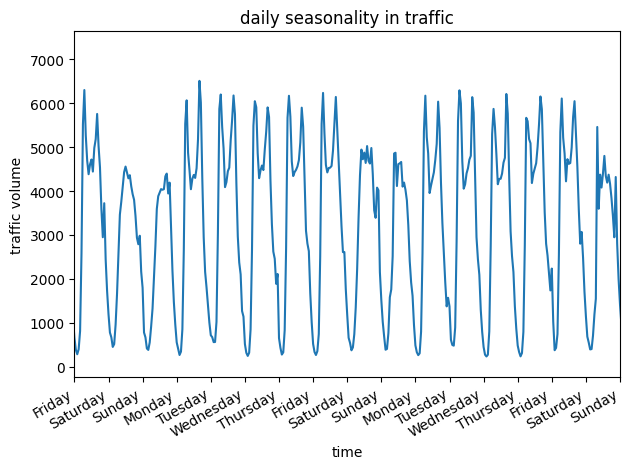

In [299]:
fig, ax = plt.subplots()
ax: Axes

ax.plot(data.index, data['traffic_volume'])
ax.set_xlabel('time')
ax.set_ylabel('traffic volume')
ax.set_title('daily seasonality in traffic')

xx: pd.DatetimeIndex = data.index[7:400:24]
ax.set_xticks(xx, xx.day_name())
ax.set_xlim(xx[0], xx[-1])

fig.autofmt_xdate()
fig.tight_layout()

In [300]:
ix = data.index
ix = ix[ix.is_year_start]
ix = pd.DatetimeIndex(dates[0] for _, dates in ix.groupby(ix.year).items())
ix

DatetimeIndex(['2017-01-01', '2018-01-01'], dtype='datetime64[ns]', freq=None)

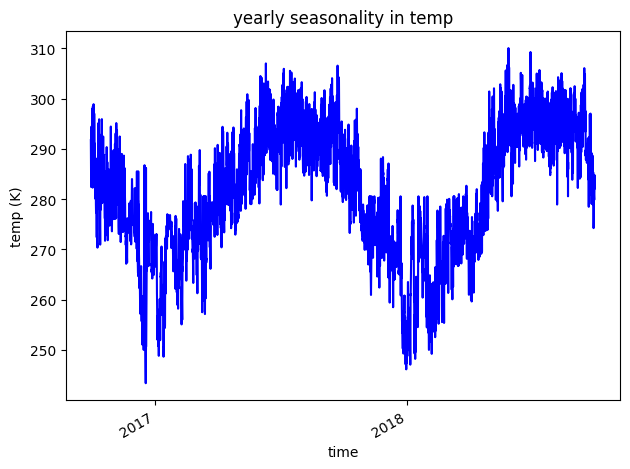

In [301]:
fig, ax = plt.subplots()
ax: Axes

ax.plot(data.index, data['temp'], 'b-')
ax.set_xlabel('time')
ax.set_ylabel('temp (K)')
ax.set_title('yearly seasonality in temp')

ax.set_xticks(ix, ix.year)

fig.autofmt_xdate()
fig.tight_layout()

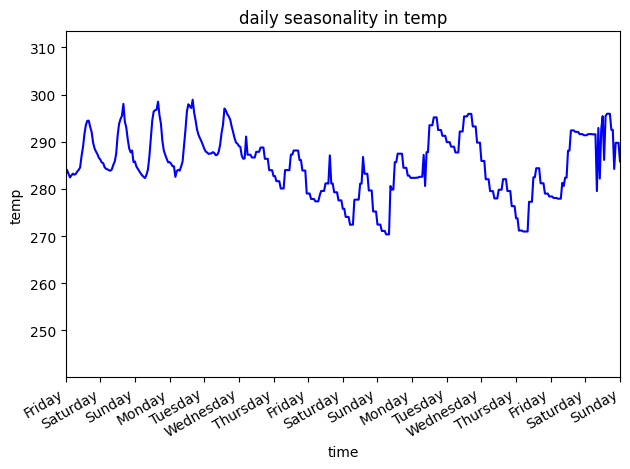

In [302]:
fig, ax = plt.subplots()
ax: Axes

ax.plot(data.index, data['temp'], 'b-')
ax.set_xlabel('time')
ax.set_ylabel('temp')
ax.set_title('daily seasonality in temp')

xx: pd.DatetimeIndex = data.index[7:400:24]
ax.set_xticks(xx, xx.day_name())
ax.set_xlim(xx[0], xx[-1])

fig.autofmt_xdate()
fig.tight_layout()

## Feature engineering and data splitting

We'll study each feature and create new ones to help our models forecast the traffic volume and hourly temperature. Finally, we'll split the data and save each set as a CSV file for later use.

In [303]:
data.head()

,temp,rain_1h,snow_1h,clouds_all,traffic_volume
date_time,,,,,
2016-09-29 17:00:00,291.75,0.0,0,0,5551.0
2016-09-29 18:00:00,290.36,0.0,0,0,4132.0
2016-09-29 19:00:00,287.86,0.0,0,0,3435.0
2016-09-29 20:00:00,285.91,0.0,0,0,2765.0
2016-09-29 21:00:00,284.31,0.0,0,0,2443.0


In [304]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
temp,17551.0,281.416203,12.688262,243.39,272.22,282.41,291.89,310.07
rain_1h,17551.0,0.025523,0.259794,0.00,0.00,0.00,0.00,10.60
snow_1h,17551.0,0.000000,0.000000,0.00,0.00,0.00,0.00,0.00
clouds_all,17551.0,42.034129,39.065960,0.00,1.00,40.00,90.00,100.00
traffic_volume,17551.0,3321.484588,1969.223949,113.00,1298.00,3518.00,4943.00,7280.00


In [305]:
def drop_columns(columns: Iterable):
    global data
    for col in columns:
        if col in data.columns:
            data = data.drop(col, axis=1)

to_drop = ['rain_1h', 'snow_1h']
drop_columns(to_drop)
data.describe().T

,count,mean,std,min,25%,50%,75%,max
temp,17551.0,281.416203,12.688262,243.39,272.22,282.41,291.89,310.07
clouds_all,17551.0,42.034129,39.065960,0.00,1.00,40.00,90.00,100.00
traffic_volume,17551.0,3321.484588,1969.223949,113.00,1298.00,3518.00,4943.00,7280.00


In [306]:
timestamp_s = data.index.map(datetime.timestamp)
day_sin = np.sin(timestamp_s*(2*np.pi/(24*60*60))).values
data['day_sin'] = day_sin

With a single sin transformation, we regain some of the cyclical property that was lost when converting to seconds. However, 12 p.m. is equivalent to 12 a.m., i.e. we can't distinguish morning from afternoon. So we'll add a `day_cos` property which, in combination with `day_sin` is unique throughout the entire 24h day.

In [307]:
data['day_cos'] = np.cos(timestamp_s*(2*np.pi/(24*60*60))).values

In [308]:
data.set_index(['day_sin', 'day_cos'], inplace=True)
data.head()

,,temp,clouds_all,traffic_volume
day_sin,day_cos,,,
0.965926,-0.258819,291.75,0,5551.0
0.866025,-0.500000,290.36,0,4132.0
0.707107,-0.707107,287.86,0,3435.0
0.500000,-0.866025,285.91,0,2765.0
0.258819,-0.965926,284.31,0,2443.0


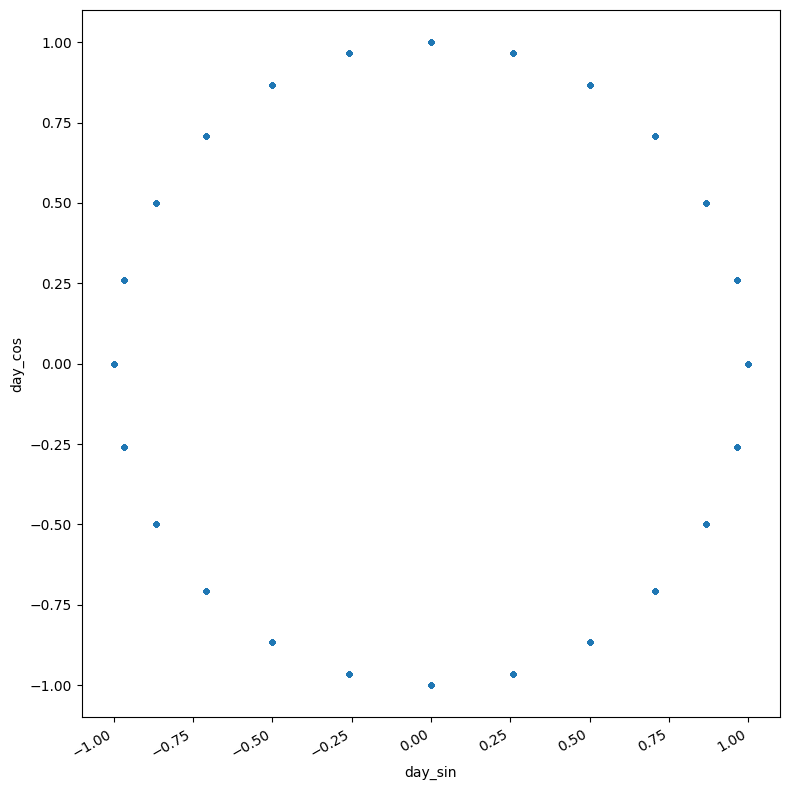

In [309]:
fig, ax = plt.subplots(figsize=(8,8))
ax: Axes

x, y = (zip(*data.index))
ax.plot(x, y, '.')
ax.set_xlabel('day_sin')
ax.set_ylabel('day_cos')

fig.autofmt_xdate()
fig.tight_layout()

In [310]:
n = len(data)
# split 70:20:10 (train:validation:test)
n1, n2 = int(n*0.7), int(n*0.9)
train_df = data[:n1]
val_df = data[n1:n2]
test_df = data[n2:]

Before saving the data, we must scale it so all values are between 0 and 1. This decreases the time required for training deep learning models and improves their performance.

In [311]:
scaler = MinMaxScaler()
scaler.fit(train_df)
train_df.loc[:] = scaler.transform(train_df)
val_df.loc[:] = scaler.transform(val_df)
test_df.loc[:] = scaler.transform(test_df)

In [312]:
train_df.to_csv('data/train.csv')
val_df.to_csv('data/val.csv')
test_df.to_csv('data/test.csv')

Note that we only scaled the data, we didn't normalize it. Normalization not only affects the data's scale but also its distribution, i.e. mean and variance, so that it is Gaussian i.e. plotting the histogram of the data would show a classic bell curve.

## Exercise: Air quality at the Beijing Aotizhongxin station

In [316]:
data = pd.read_csv('data/beijing_air_quality.csv')
data.loc[:, 'datetime'] = pd.to_datetime(data['datetime'])
data.set_index('datetime', inplace=True)
data.head()

,No,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
datetime,,,,,,,,,,,,,,
2015-01-02 22:00:00,16151,118.0,147.0,58.0,100.0,2000.0,2.0,-5.0,1021.0,-17.2,0.0,SW,0.7,Aotizhongxin
2015-01-02 23:00:00,16152,137.0,179.0,63.0,101.0,2100.0,2.0,-6.0,1018.0,-14.3,0.0,NNW,0.7,Aotizhongxin
2015-01-03 00:00:00,16153,141.0,215.0,59.0,100.0,2300.0,2.0,-7.0,1016.0,-15.9,0.0,SSE,0.4,Aotizhongxin
2015-01-03 01:00:00,16154,136.0,158.0,65.0,106.0,3000.0,2.0,-7.0,1016.0,-12.7,0.0,ESE,0.4,Aotizhongxin
2015-01-03 02:00:00,16155,132.0,163.0,56.0,107.0,3000.0,2.0,-6.0,1014.0,-16.9,0.0,NE,1.1,Aotizhongxin


In [317]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
No,18914.0,25607.500000,5460.145831,16151.0,20879.250,25607.5,30335.75,35064.0
PM2.5,18914.0,79.407220,83.816615,3.0,19.000,54.0,107.00,898.0
PM10,18914.0,103.687485,95.725767,3.0,33.225,78.0,143.00,984.0
SO2,18914.0,13.201725,17.090182,2.0,2.000,7.0,16.00,341.0
NO2,18914.0,55.560272,37.834273,2.0,26.000,47.0,77.00,290.0
CO,18914.0,1324.737573,1351.213878,100.0,500.000,900.0,1600.00,10000.0
O3,18914.0,61.602319,58.980450,2.0,13.000,49.0,87.00,423.0
TEMP,18914.0,12.741331,11.751367,-16.8,2.000,13.0,23.10,38.8
PRES,18914.0,1013.480721,10.470266,987.5,1004.900,1013.2,1022.10,1042.0
DEWP,18914.0,1.399363,13.830859,-35.3,-10.100,1.3,14.00,27.3


In [318]:
data.drop(['RAIN', 'wd', 'station'], axis=1, inplace=True)

,No,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,WSPM
datetime,,,,,,,,,,,
2015-01-02 22:00:00,16151,118.0,147.0,58.0,100.0,2000.0,2.0,-5.0,1021.0,-17.2,0.7
2015-01-02 23:00:00,16152,137.0,179.0,63.0,101.0,2100.0,2.0,-6.0,1018.0,-14.3,0.7
2015-01-03 00:00:00,16153,141.0,215.0,59.0,100.0,2300.0,2.0,-7.0,1016.0,-15.9,0.4
2015-01-03 01:00:00,16154,136.0,158.0,65.0,106.0,3000.0,2.0,-7.0,1016.0,-12.7,0.4
2015-01-03 02:00:00,16155,132.0,163.0,56.0,107.0,3000.0,2.0,-6.0,1014.0,-16.9,1.1
...,...,...,...,...,...,...,...,...,...,...,...
2015-01-31 20:00:00,16845,67.0,100.0,28.0,70.0,1200.0,11.0,-1.0,1030.0,-19.6,1.5
2015-01-31 21:00:00,16846,88.0,119.0,36.0,84.0,1600.0,3.0,-4.0,1031.0,-19.9,1.3
2015-01-31 22:00:00,16847,103.0,129.0,38.0,93.0,1800.0,2.0,-6.0,1033.0,-19.0,0.2


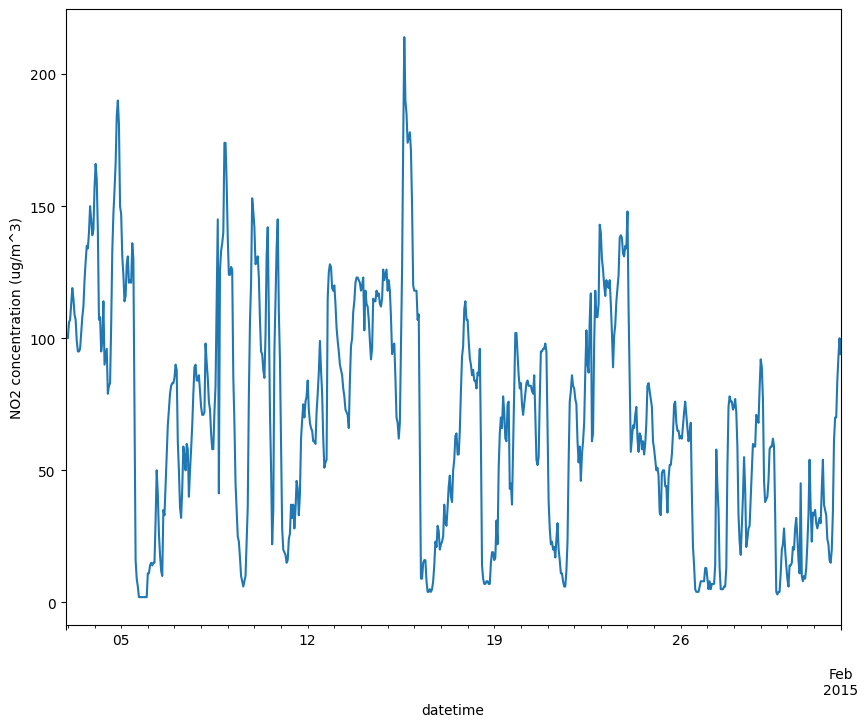

In [329]:
data['NO2'].loc[datetime(2015, 1, 1):datetime(2015, 2, 1)].plot(figsize=(10,8), ylabel='NO2 concentration (ug/m^3)');

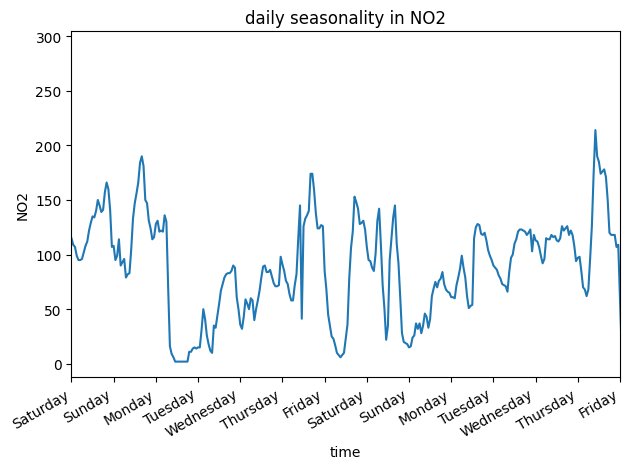

In [284]:
fig, ax = plt.subplots()
ax: Axes

ax.plot(data.index, data['NO2'])
ax.set_xlabel('time')
ax.set_ylabel('NO2')
ax.set_title('daily seasonality in NO2')

xx: pd.DatetimeIndex = data.index[7:24*14:24]
ax.set_xticks(xx, xx.day_name())
ax.set_xlim(xx[0], xx[-1])

fig.autofmt_xdate()
fig.tight_layout()

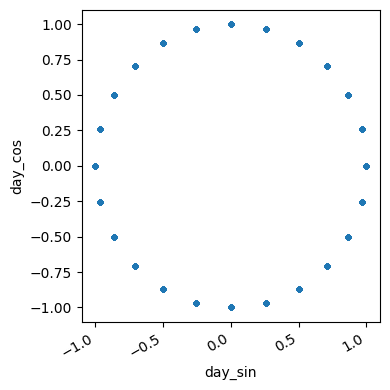

In [330]:
timestamp_s = data.index.map(datetime.timestamp)
data['day_sin'] = np.sin(timestamp_s*(2*np.pi/(24*60*60))).values
data['day_cos'] = np.cos(timestamp_s*(2*np.pi/(24*60*60))).values
data.set_index(['day_sin', 'day_cos'], inplace=True)

fig, ax = plt.subplots(figsize=(4,4))
ax: Axes
x, y = (zip(*data.index))
ax.plot(x, y, '.')
ax.set_xlabel('day_sin')
ax.set_ylabel('day_cos')
fig.autofmt_xdate()
fig.tight_layout()

In [286]:
n = len(data)
n1, n2 = int(n*0.7), int(n*0.9)
train = data.iloc[:n1]
val = data.iloc[n1:n2]
test = data.iloc[n2:]

In [287]:
scaler = MinMaxScaler()
train.loc[:] = scaler.fit_transform(train)
val.loc[:] = scaler.transform(val)
test.loc[:] = scaler.transform(test)

In [288]:
train_df.to_csv('data/beijing_train.csv')
val_df.to_csv('data/beijing_val.csv')
test_df.to_csv('data/beijing_test.csv')